# Self Organizing Map

## Install MiniSom Package

In [1]:
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.6-cp37-none-any.whl size=8531 sha256=81ac37003e65bb8f8ce5d0cc4785545ebbd65134242bbfa3941612fa326cef72
  Stored in directory: C:\Users\pc\AppData\Local\pip\Cache\wheels\b8\c6\01\330066e36e1f7c826c96f656f9185822cfcdef0591315949ea
Successfully built MiniSom


### Importing the libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [3]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

## Feature Scaling


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Training the SOM


In [5]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

## Visualizing the results


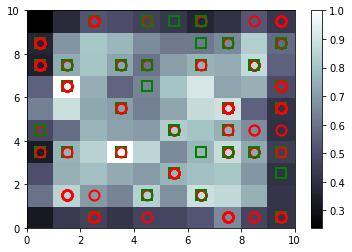

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## Finding the frauds


In [7]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(1,1)], mappings[(4,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

## Printing the Fraunch Clients

In [8]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15813718
15815271
15744273
15773934
15694237
15805627
15692718
15789865
15618703
15757933
15677395
15692137
15676909
